In [278]:
# Extract data
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

### Read meteorological data
Using Data.gov API

- RH_monthly_mean: "https://data.gov.sg/dataset/relative-humidity-monthly-mean"

- rainfall_monthly_count: "https://data.gov.sg/dataset/rainfall-monthly-number-of-rain-days"

- rainfall_monthly_total: "https://data.gov.sg/dataset/rainfall-monthly-total"

- Surface Air Temperature_monthly_mean: "https://data.gov.sg/dataset/surface-air-temperature-monthly-mean"

- Sunshine Duration monthly_mean: "https://data.gov.sg/dataset/sunshine-duration-monthly-mean-daily-duration"

In [279]:
import requests

In [280]:
# Resource ids are obtained from the data.gov.sg website (Data API)
resource_ids = {
    "RH" : '4631174f-9858-463d-8a88-f3cb21588c67',
    "Rainfall_count" : '8b94f596-91fd-4545-bf9e-7a426493b674',
    "Rainfall_total" : '778814b8-1b96-404b-9ac9-68d6c00e637b',
    "SA Temp" : '07654ce7-f97f-49c9-81c6-bd41beba4e96',
    "Sunshine" : '0230819f-1c83-4980-b738-56136d6dc300'
}

# since we want all the data, we set the limit to be the maximum value of a 64-bit integer
limit = 9223372036854775807

data = []
# Meteorological data
for key in resource_ids:
    url = f"https://data.gov.sg/api/action/datastore_search?resource_id={resource_ids[key]}&limit={limit}"
    r = requests.get(url)
    data.append(pd.DataFrame(r.json().get('result').get('records')))

In [281]:
# Basic Cleaning
# Merge all the data in the list into one dataframe
meteorological = pd.concat(data, join='inner', axis=1)

# Get all the rows for first column of 'month' (there exists multiple columns with the name 'month')
date_value = meteorological['month'].iloc[:,0]

# Make the date a new column at the start (with the name called 'date')
meteorological.insert(loc=0, column='date', value=date_value)

# Delete the duplicate columns ('month' and '_id')
meteorological.drop(['month', '_id'], axis=1, inplace=True)
display(meteorological)

,date,mean_rh,no_of_rainy_days,total_rainfall,mean_temp,mean_sunshine_hrs
0,1982-01,81.2,10,107.1,25.9,5.6
1,1982-02,79.5,5,27.8,27.1,7.6
2,1982-03,82.3,11,160.8,27.2,5.1
3,1982-04,85.9,14,157,27,4.7
4,1982-05,83.2,10,102.2,28,5.8
...,...,...,...,...,...,...
487,2022-08,77.4,15,141.4,28.1,5.5
488,2022-09,76.9,14,121,27.9,3.8
489,2022-10,78.7,27,279,27.6,3.5
490,2022-11,79.9,26,313.8,27.4,3.8


In [282]:
# Get a basic summary of the data
print(f"Shape: {meteorological.shape}")
print(f"Data types:\n{meteorological.dtypes}")
# Check for missing values
meteorological.isnull().sum()

Shape: (492, 6)
Data types:
date                 object
mean_rh              object
no_of_rainy_days     object
total_rainfall       object
mean_temp            object
mean_sunshine_hrs    object
dtype: object


date                 0
mean_rh              0
no_of_rainy_days     0
total_rainfall       0
mean_temp            0
mean_sunshine_hrs    0
dtype: int64

In [283]:
# Reformat the date column into date object
meteorological['date'] = pd.to_datetime(meteorological['date'])

# Convert all data (except date) to numeric
meteorological.iloc[:,1:] = meteorological.iloc[:,1:].apply(pd.to_numeric)

In [284]:
# Resample the data and reduce its granularity to yearly (so that we can compare with our other data)
meteorological = meteorological.resample('Y', on='date').aggregate({'mean_rh': ['mean', 'median', 'max', 'min'], 'no_of_rainy_days': 'sum', 'total_rainfall': 'sum', 'mean_temp': ['mean', 'median', 'max', 'min'], 'mean_sunshine_hrs': ['mean', 'median', 'max', 'min']})

# Rename the columns based on their aggregation functions
meteorological.columns = ['mean_annual_rh', 'median_annual_rh', 'max_annual_rh', 'min_annual_rh', 'annual_num_of_rainy_days', 'total_annual_precipitation', 'mean_annual_temp', 'median_annual_temp', 'max_annual_temp', 'min_annual_temp', 'mean_annual_sunshine_hrs', 'median_annual_sunshine_hrs', 'max_annual_sunshine_hrs', 'min_annual_sunshine_hrs']

# Reset the index so that the date is a column again
meteorological.reset_index(inplace=True)

# Convert date column to only have year
meteorological['date'] = meteorological['date'].dt.year
# Rename the date column to year
meteorological.rename(columns={'date': 'year'}, inplace=True)

# Add a new column total_mean_precipitation which is total_annual_precipitation / num of days in the year
# A leap year is exactly divisible by 4 except for century years (years ending with 00). The century year is a leap year only if it is perfectly divisible by 400.
num_of_days = meteorological['year'].apply(lambda x: 366 if ((x % 4 == 0 and x % 100 != 0) or (x % 400 == 0  and x % 100 == 0)) else 365)
meteorological.insert(loc=7, column='total_mean_precipitation', value=(meteorological['total_annual_precipitation'])/num_of_days)

# Round the data to 2 decimal places
meteorological = meteorological.round(2)
display(meteorological)

,year,mean_annual_rh,median_annual_rh,max_annual_rh,min_annual_rh,annual_num_of_rainy_days,total_annual_precipitation,total_mean_precipitation,mean_annual_temp,median_annual_temp,max_annual_temp,min_annual_temp,mean_annual_sunshine_hrs,median_annual_sunshine_hrs,max_annual_sunshine_hrs,min_annual_sunshine_hrs
0,1982,81.97,81.35,87.7,77.6,130,1581.7,4.33,27.36,27.35,28.4,25.9,5.75,5.60,7.6,3.3
1,1983,82.28,82.85,88.0,76.0,145,1993.7,5.46,27.67,27.85,29.4,25.4,5.62,5.65,9.3,2.7
2,1984,84.62,84.10,86.7,82.5,191,2686.7,7.34,26.77,27.00,27.5,25.5,5.08,5.30,6.4,3.3
3,1985,83.21,83.60,86.2,79.4,181,1483.9,4.07,27.12,27.00,28.2,26.1,5.59,5.55,8.7,4.1
4,1986,82.87,84.00,86.6,77.3,174,2536.1,6.95,27.10,26.90,28.3,25.7,5.52,5.50,7.2,3.9
5,1987,82.87,83.00,86.0,79.0,151,2102.8,5.76,27.38,27.55,28.7,25.5,5.92,5.70,9.2,4.0
6,1988,83.84,84.15,86.8,81.1,173,2598.6,7.10,27.23,27.20,28.4,26.2,5.38,5.50,6.7,3.7
7,1989,84.35,84.25,87.6,78.3,173,2463.2,6.75,26.92,26.95,27.7,26.3,5.53,5.50,6.7,4.5
8,1990,82.21,82.50,86.0,77.6,142,1523.8,4.17,27.59,27.55,28.6,26.2,6.20,5.90,8.9,4.6
9,1991,83.13,82.30,90.7,78.7,146,1877.0,5.14,27.43,27.60,28.6,25.6,5.38,5.45,7.1,3.0


In [285]:
display(meteorological.describe())

,year,mean_annual_rh,median_annual_rh,max_annual_rh,min_annual_rh,annual_num_of_rainy_days,total_annual_precipitation,total_mean_precipitation,mean_annual_temp,median_annual_temp,max_annual_temp,min_annual_temp,mean_annual_sunshine_hrs,median_annual_sunshine_hrs,max_annual_sunshine_hrs,min_annual_sunshine_hrs
count,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000
mean,2002.000000,82.222927,82.237805,86.351220,78.341463,169.463415,2131.343902,5.835122,27.676829,27.745122,28.726829,26.390244,5.671951,5.665854,7.770732,3.797561
std,11.979149,2.442765,2.575504,2.417863,2.680669,23.053305,451.595838,1.236006,0.384892,0.404939,0.433027,0.486212,0.361879,0.399600,0.829230,0.508669
min,1982.000000,75.950000,76.250000,79.600000,72.000000,116.000000,1118.900000,3.070000,26.770000,26.900000,27.500000,25.400000,5.050000,4.900000,6.400000,2.700000
25%,1992.000000,81.970000,81.700000,86.000000,77.000000,152.000000,1886.600000,5.150000,27.460000,27.550000,28.400000,26.200000,5.420000,5.400000,7.100000,3.500000
50%,2002.000000,83.130000,83.200000,86.800000,78.700000,175.000000,2136.400000,5.850000,27.610000,27.750000,28.700000,26.500000,5.620000,5.600000,7.700000,3.700000
75%,2012.000000,83.840000,84.100000,87.600000,80.500000,184.000000,2463.200000,6.750000,27.910000,28.050000,29.000000,26.700000,5.920000,5.850000,8.300000,4.200000
max,2022.000000,84.740000,84.950000,90.700000,82.500000,210.000000,2886.200000,7.910000,28.420000,28.500000,29.500000,27.400000,6.780000,6.850000,9.300000,4.800000


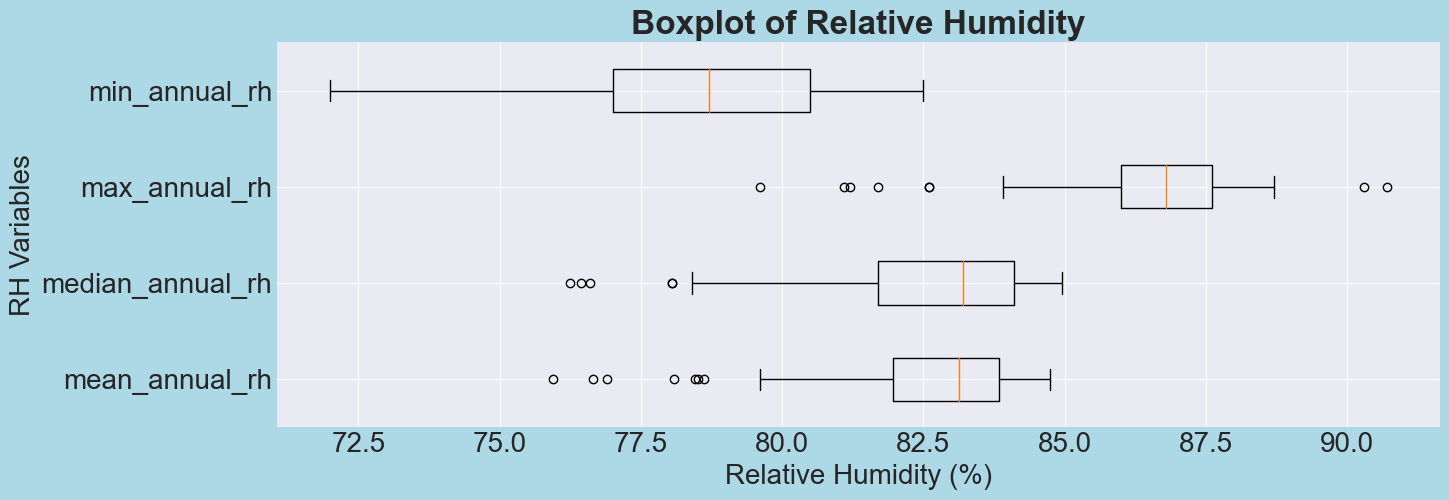

In [286]:
# Plot the boxplots of relative humidity horizontally
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax.boxplot(meteorological.iloc[:,1:5], vert=False)
ax.set_yticklabels(meteorological.columns[1:5])

# Title
plt.title("Boxplot of Relative Humidity")
plt.rcParams.update({'font.size': 20})
plt.title("Boxplot of Relative Humidity", fontweight="bold")

# Label the axes
plt.xlabel("Relative Humidity (%)")
plt.ylabel("RH Variables")

# Style
fig.set_facecolor("lightblue")
plt.style.use('seaborn-v0_8-darkgrid')

plt.show()

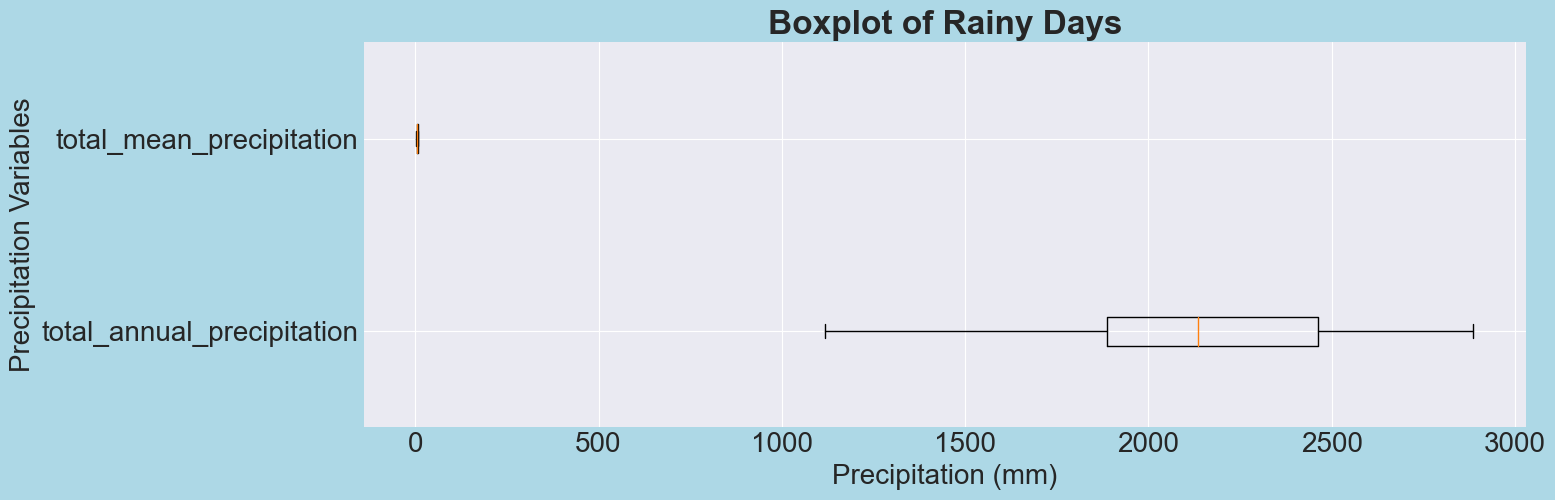

In [287]:
# Plot the boxplots of precipitation horizontally
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax.boxplot(meteorological.iloc[:,6:8], vert=False)
ax.set_yticklabels(meteorological.columns[6:8])

# Title
plt.title("Boxplot of Precipitation")
plt.rcParams.update({'font.size': 20})
plt.title("Boxplot of Rainy Days", fontweight="bold")

# Label the axes
plt.xlabel("Precipitation (mm)")
plt.ylabel("Precipitation Variables")

# Style
fig.set_facecolor("lightblue")
plt.style.use('seaborn-v0_8-darkgrid')

plt.show()

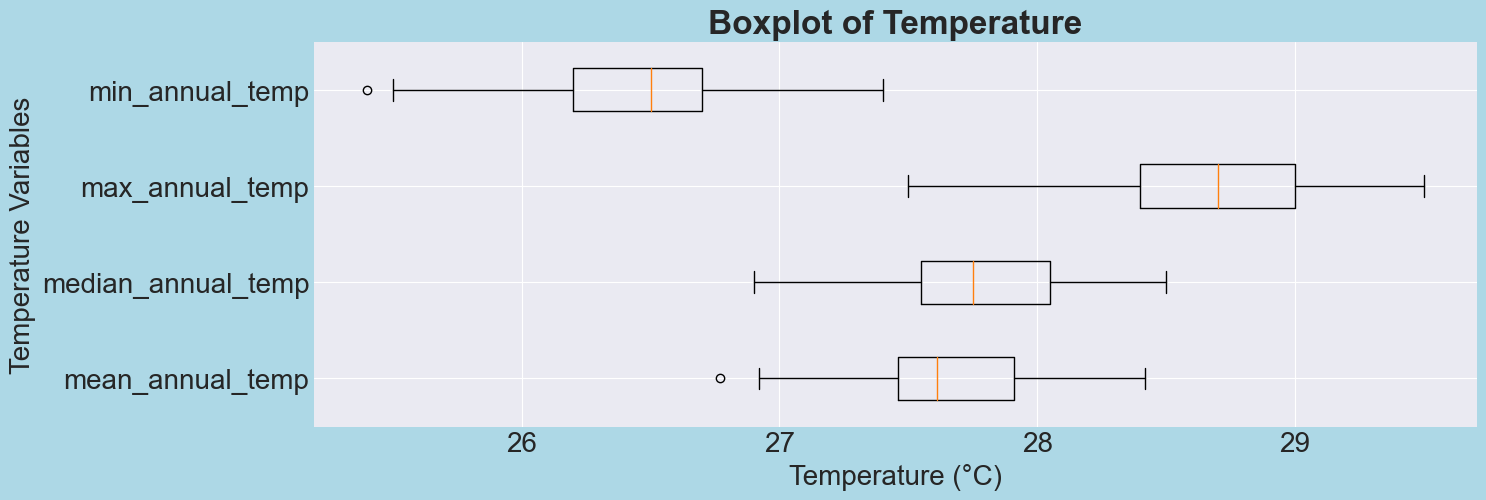

In [288]:
# Plot the boxplots of temperature horizontally
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax.boxplot(meteorological.iloc[:,8:12], vert=False)
ax.set_yticklabels(meteorological.columns[8:12])

# Title
plt.title("Boxplot of Temperature")
plt.rcParams.update({'font.size': 20})
plt.title("Boxplot of Temperature", fontweight="bold")

# Label the axes
plt.xlabel("Temperature (°C)")
plt.ylabel("Temperature Variables")

# Style
fig.set_facecolor("lightblue")
plt.style.use('seaborn-v0_8-darkgrid')

plt.show()

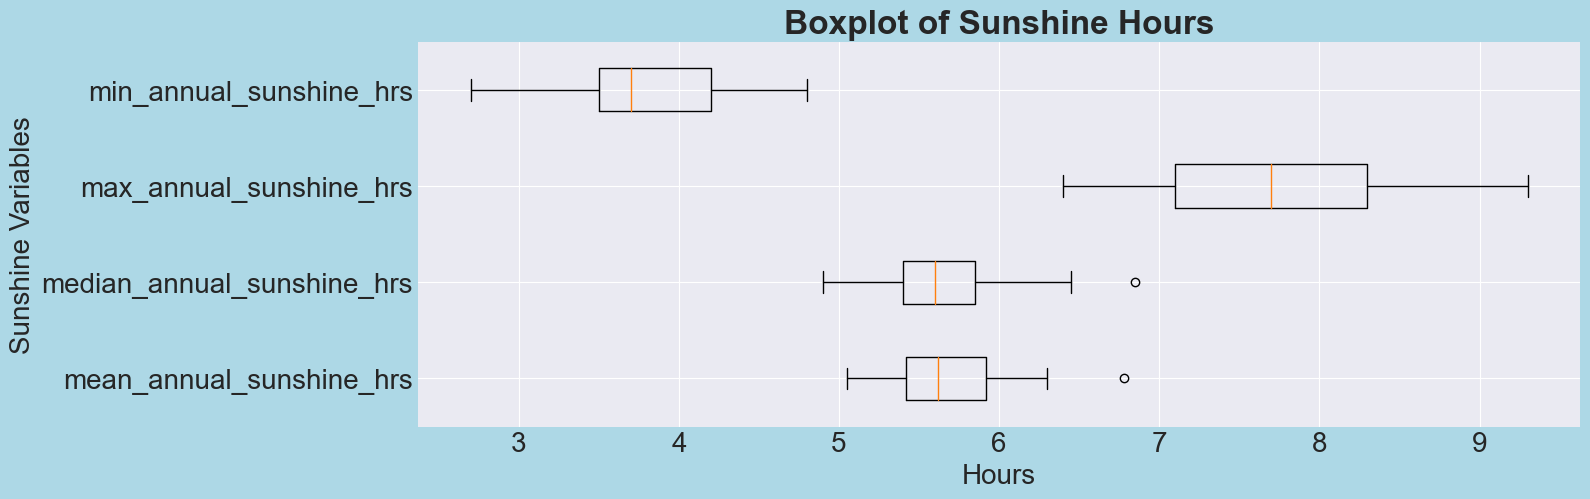

In [289]:
# Plot the boxplots of sunshine hours horizontally
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax.boxplot(meteorological.iloc[:,12:16], vert=False)
ax.set_yticklabels(meteorological.columns[12:16])

# Title
plt.title("Boxplot of Sunshine Hours")
plt.rcParams.update({'font.size': 20})
plt.title("Boxplot of Sunshine Hours", fontweight="bold")

# Label the axes
plt.xlabel("Hours")
plt.ylabel("Sunshine Variables")

# Style
fig.set_facecolor("lightblue")
plt.style.use('seaborn-v0_8-darkgrid')

plt.show()

In [290]:
# From the boxplots, we can see that most of the data don't have outliers other than the relative humidity data
# We will use the IQR method to check if there is any pattern in the outliers

# Calculate the IQR
# Get all columns with 'rh' in it
rh_data = meteorological.filter(regex='rh')
# Get the IQR of each column
rh_iqr = rh_data.quantile(0.75) - rh_data.quantile(0.25)
# Get the upper and lower bounds
rh_upper_bound = rh_data.quantile(0.75) + 1.5 * rh_iqr
rh_lower_bound = rh_data.quantile(0.25) - 1.5 * rh_iqr

# Get the outliers
rh_outliers = meteorological[(meteorological['mean_annual_rh'] > rh_upper_bound['mean_annual_rh']) | (meteorological['mean_annual_rh'] < rh_lower_bound['mean_annual_rh']) | (meteorological['median_annual_rh'] > rh_upper_bound['median_annual_rh']) | (meteorological['median_annual_rh'] < rh_lower_bound['median_annual_rh']) | (meteorological['max_annual_rh'] > rh_upper_bound['max_annual_rh']) | (meteorological['max_annual_rh'] < rh_lower_bound['max_annual_rh']) | (meteorological['min_annual_rh'] > rh_upper_bound['min_annual_rh']) | (meteorological['min_annual_rh'] < rh_lower_bound['min_annual_rh'])][['year', *[cols for cols in rh_data]]]

display(rh_outliers)

,year,mean_annual_rh,median_annual_rh,max_annual_rh,min_annual_rh
9,1991,83.13,82.30,90.7,78.7
10,1992,83.31,82.55,90.3,80.5
32,2014,78.52,78.40,82.6,74.5
33,2015,76.90,76.25,81.1,74.9
34,2016,75.95,76.45,79.6,72.0
37,2019,76.65,76.60,83.9,72.1
38,2020,78.08,78.05,81.7,75.2
39,2021,78.45,78.05,82.6,73.8
40,2022,78.62,78.90,81.2,76.5


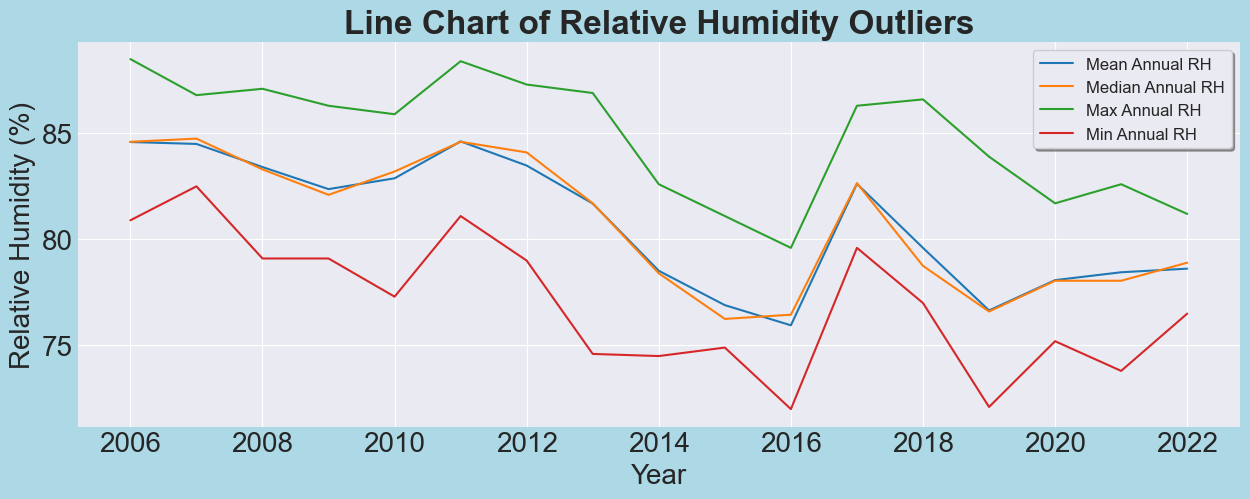

In [291]:
# Plot line chart of relative humidity outliers (from 10 years before 2014)
rh_data.insert(loc=0, column='year', value=meteorological['year'])
rh_data = rh_data[rh_data['year'] > 2005]

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax.plot(rh_data['year'], rh_data['mean_annual_rh'], label='Mean Annual RH')
ax.plot(rh_data['year'], rh_data['median_annual_rh'], label='Median Annual RH')
ax.plot(rh_data['year'], rh_data['max_annual_rh'], label='Max Annual RH')
ax.plot(rh_data['year'], rh_data['min_annual_rh'], label='Min Annual RH')

# Title
plt.title("Line Chart of Relative Humidity Outliers")
plt.rcParams.update({'font.size': 20})
plt.title("Line Chart of Relative Humidity Outliers", fontweight="bold")

# Style
fig.set_facecolor("lightblue")
plt.style.use('seaborn-v0_8-darkgrid')

# Make the white box around the legend and give it a shadow
plt.legend(frameon=True, shadow=True, fontsize=12, loc='upper right')

# Label the axes
plt.xlabel("Year")
plt.ylabel("Relative Humidity (%)")

plt.show()

### Reading Pollution
Using Singstat API https://tablebuilder.singstat.gov.sg/table/TS/M890641n

In [292]:
# Use the data from the tablebuilder website to get resource id
url = "https://tablebuilder.singstat.gov.sg/api/table/resourceid?keyword=Air Pollution&searchOption=all"

r = requests.get(url)
print(r)
resource_id = r.json()['Data']['records'][0]['id']

<Response [200]>


In [293]:
# resource_id = 'M890641'

# Get the data from the resource id
url = f"https://tablebuilder.singstat.gov.sg/api/table/tabledata/{resource_id}"
r = requests.get(url)

# Convert the data into a dataframe
data = r.json()['Data']['row']

pollution = pd.DataFrame()
for item in data:
    row = item['columns']
    row_df = pd.DataFrame(row)
    row_df = row_df.set_index('key')
    row_df = row_df.rename(columns={'value': item['rowText']})
    pollution = pollution.join(row_df, how='outer')

pollution.reset_index(inplace=True)
pollution.rename(columns={'key': 'year'}, inplace=True)
display(pollution)

,year,Sulphur Dioxide (Maximum 24-Hour Mean),Nitrogen Dioxide (Annual Mean),Nitrogen Dioxide (Maximum 1-Hour Mean),Particulate Matter (PM10) (Annual Mean),Particulate Matter (PM10) (99th Percentile 24-Hour Mean),Particulate Matter (PM2.5) (Annual Mean),Particulate Matter (PM2.5) (99th Percentile 24-Hour Mean),Carbon Monoxide (Maximum 8-Hour Mean),Carbon Monoxide (Maximum 1-Hour Mean),Ozone (Maximum 8-Hour Mean)
0,2007,84,22,177,27,53,19,37,1.7,2.5,206
1,2008,80,22,126,25,49,16,32,1.6,2.3,183
2,2009,93,22,147,29,59,19,44,1.9,3.9,105
3,2010,104,23,153,26,76,17,56,2.4,2.8,139
4,2011,80,25,189,27,55,17,41,2,2.6,123
5,2012,98,25,154,29,57,19,42,1.9,2.4,122
6,2013,75,25,132,31,215,20,176,5.5,7.5,139
7,2014,83,24,121,30,75,18,51,1.8,2.7,135
8,2015,75,22,99,37,186,24,145,3.3,3.5,152
9,2016,61,26,123,26,61,15,40,2.2,2.7,115


In [294]:
# Rename the columns to be more meaningful
pollution.rename(columns={'year': 'year', 'Particulate Matter (PM2.5) (Annual Mean)' : 'PM2.5_mean', 'Particulate Matter (PM10) (Annual Mean)': 'PM10_mean', 'Particulate Matter (PM10) (99th Percentile 24-Hour Mean)':'PM10 99th_pctl', 'Particulate Matter (PM2.5) (99th Percentile 24-Hour Mean)':'PM2.5 99th_pctl', 'Sulphur Dioxide (Maximum 24-Hour Mean)': 'SO2_mean', 'Nitrogen Dioxide (Annual Mean)': 'NO2_mean', 'Nitrogen Dioxide (Maximum 1-Hour Mean)': 'NO2_1hr_mean', 'Carbon Monoxide (Maximum 8-Hour Mean)' : 'CO_mean', 'Carbon Monoxide (Maximum 8-Hour Mean)': 'CO_mean', 'Carbon Monoxide (Maximum 1-Hour Mean)':'CO_1hr_mean', 'Ozone (Maximum 8-Hour Mean)': 'O3_mean'}, inplace=True)

In [295]:
# Get a basic summary of the data
print(f"Shape: {pollution.shape}")
print(f"Data types:\n{pollution.dtypes}")
# Check for missing values
pollution.isnull().sum()

Shape: (15, 11)
Data types:
year               object
SO2_mean           object
NO2_mean           object
NO2_1hr_mean       object
PM10_mean          object
PM10 99th_pctl     object
PM2.5_mean         object
PM2.5 99th_pctl    object
CO_mean            object
CO_1hr_mean        object
O3_mean            object
dtype: object


year               0
SO2_mean           0
NO2_mean           0
NO2_1hr_mean       0
PM10_mean          0
PM10 99th_pctl     0
PM2.5_mean         0
PM2.5 99th_pctl    0
CO_mean            0
CO_1hr_mean        0
O3_mean            0
dtype: int64

In [296]:
# Convert everything to numeric
pollution.iloc[:,:] = pollution.iloc[:,:].apply(pd.to_numeric)

In [297]:
# Get a basic summary of the data
print(f"Shape: {pollution.shape}")
print(f"Data types:\n{pollution.dtypes}")
# Check for missing values
pollution.isnull().sum()

Shape: (15, 11)
Data types:
year                 int64
SO2_mean             int64
NO2_mean             int64
NO2_1hr_mean         int64
PM10_mean            int64
PM10 99th_pctl       int64
PM2.5_mean           int64
PM2.5 99th_pctl      int64
CO_mean            float64
CO_1hr_mean        float64
O3_mean              int64
dtype: object


year               0
SO2_mean           0
NO2_mean           0
NO2_1hr_mean       0
PM10_mean          0
PM10 99th_pctl     0
PM2.5_mean         0
PM2.5 99th_pctl    0
CO_mean            0
CO_1hr_mean        0
O3_mean            0
dtype: int64

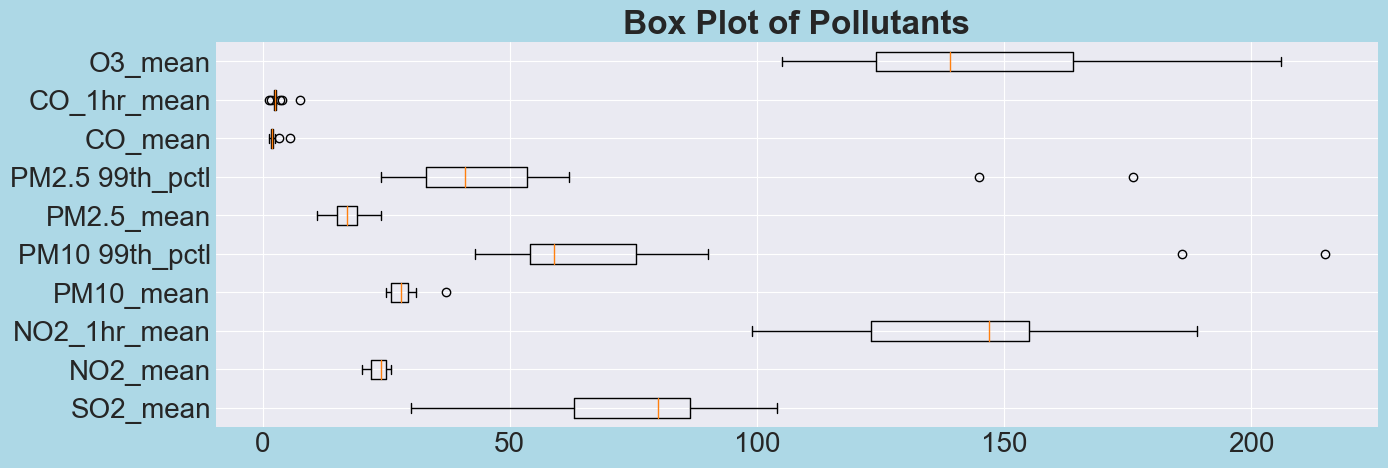

In [298]:
# Plot box plot of pollutants to check for outliers
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax.boxplot(pollution.iloc[:,1:], vert=False)
ax.set_yticklabels(pollution.columns[1:])

# Title
plt.title("Box Plot of Pollutants")
plt.rcParams.update({'font.size': 20})
plt.title("Box Plot of Pollutants", fontweight="bold")

# Style
fig.set_facecolor("lightblue")
plt.style.use('seaborn-v0_8-darkgrid')

plt.show()


In [299]:
# Calculate the IQR
# Get all columns with 'CO' in it
CO_data = pollution.filter(regex='CO')
# Get the IQR of each column
CO_iqr = CO_data.quantile(0.75) - CO_data.quantile(0.25)
# Get the upper and lower bounds
CO_upper_bound = CO_data.quantile(0.75) + (1.5 * CO_iqr)
CO_lower_bound = CO_data.quantile(0.25) - (1.5 * CO_iqr)

# Get the outliers
CO_outliers = pollution[(pollution['CO_mean'] > CO_upper_bound['CO_mean']) | (pollution['CO_mean'] < CO_lower_bound['CO_mean']) | (pollution['CO_1hr_mean'] > CO_upper_bound['CO_1hr_mean']) | (pollution['CO_1hr_mean'] < CO_lower_bound['CO_1hr_mean'])][['year', *[col for col in CO_data.columns]]]


display(CO_outliers)

,year,CO_mean,CO_1hr_mean
2,2009,1.9,3.9
6,2013,5.5,7.5
8,2015,3.3,3.5
13,2020,1.2,1.6
14,2021,1.2,1.3


In [311]:
# Get ouliers for PM2.5 and PM10
PM_data = pollution.filter(regex='99th')
PM_iqr = PM_data.quantile(0.75) - PM_data.quantile(0.25)

PM_upper_bound = PM_data.quantile(0.75) + (1.5 * PM_iqr)
PM_lower_bound = PM_data.quantile(0.25) - (1.5 * PM_iqr)

PM_outliers = pollution[(pollution['PM2.5 99th_pctl'] > PM_upper_bound['PM2.5 99th_pctl']) | (pollution['PM2.5 99th_pctl'] < PM_lower_bound['PM2.5 99th_pctl']) | (pollution['PM10 99th_pctl'] > PM_upper_bound['PM10 99th_pctl']) | (pollution['PM10 99th_pctl'] < PM_lower_bound['PM10 99th_pctl'])][['year', *[col for col in PM_data.columns]]]

display(PM_outliers)


,year,PM10 99th_pctl,PM2.5 99th_pctl
6,2013,215,176
8,2015,186,145


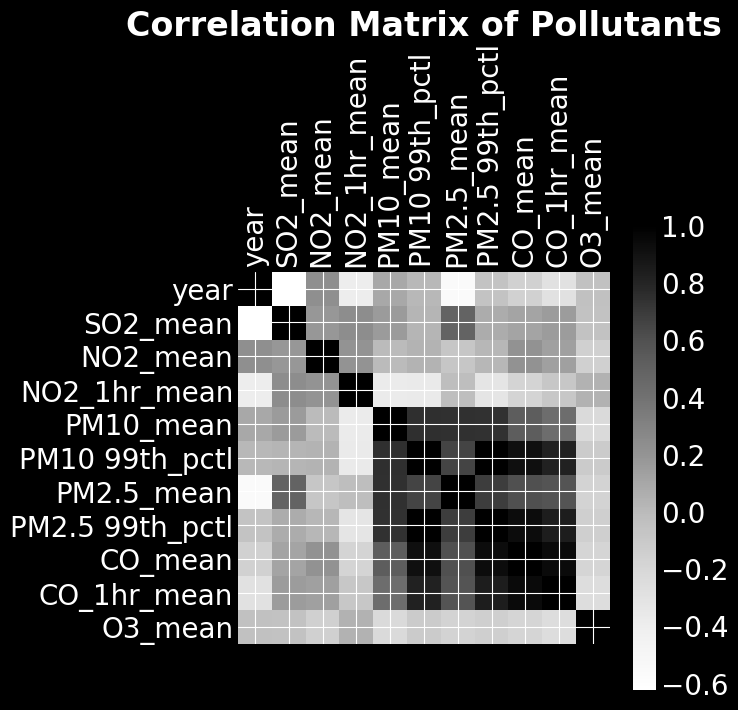

In [300]:
# Plot a correlation matrix to see the correlation between the different pollutants
fig = plt.figure(figsize=(6,6))

# Set all text to white
mpl.rcParams['text.color'] = 'white'
# Set all ticks to white
mpl.rcParams['xtick.color'] = 'white'
mpl.rcParams['ytick.color'] = 'white'


# Plot using matplotlib
plt.matshow(pollution.corr(), fignum=1)
plt.xticks(range(len(pollution.columns)), pollution.columns, rotation=90)
plt.yticks(range(len(pollution.columns)), pollution.columns)
plt.colorbar()

# Title
plt.title("Correlation Matrix of Pollutants")
plt.rcParams.update({'font.size': 20})
plt.title("Correlation Matrix of Pollutants", fontweight="bold")

# Style
plt.style.use('default')
fig.set_facecolor("black")


plt.show()

### Reading Energy Consumption

Using web-scraping: https://main--jolly-kelpie-43bb8d.netlify.app/table.html

*Note this is a statically hosted website. The orignal dataset can be found here: https://www.ema.gov.sg/statistic.aspx?sta_sid=20141211NBOOXgSCZ0no

In [301]:
from bs4 import BeautifulSoup

url = "https://main--jolly-kelpie-43bb8d.netlify.app/table.html"
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
table = soup.find_all('table')[0] 
energy_consumption = pd.read_html(str(table))[0]

display(energy_consumption)

,year,sector,energy_products,consumption_ktoe
0,2009,Commerce and Services-related,Coal and Peat,0.0
1,2009,Commerce and Services-related,Crude Oil,0.0
2,2009,Commerce and Services-related,Electricity,1272.6
3,2009,Commerce and Services-related,Natural Gas,72.9
4,2009,Commerce and Services-related,Others,0.0
...,...,...,...,...
355,2020,Transport-related,Crude Oil,0.0
356,2020,Transport-related,Electricity,241.5
357,2020,Transport-related,Natural Gas,2.0
358,2020,Transport-related,Others,0.0


In [302]:
print(energy_consumption.sector.unique())

['Commerce and Services-related' 'Households' 'Industry-related' 'Others'
 'Transport-related']


In [303]:
# Replace all the column with values 'related' and 'and'
energy_consumption['sector'] = energy_consumption['sector'].replace('.related', '', regex=True)
energy_consumption['sector'] = energy_consumption['sector'].replace('and', '&', regex=True)
print(energy_consumption.sector.unique())

['Commerce & Services' 'Households' 'Industry' 'Others' 'Transport']


In [304]:
# Check for missing data
print(energy_consumption.isnull().sum())

year                0
sector              0
energy_products     0
consumption_ktoe    0
dtype: int64


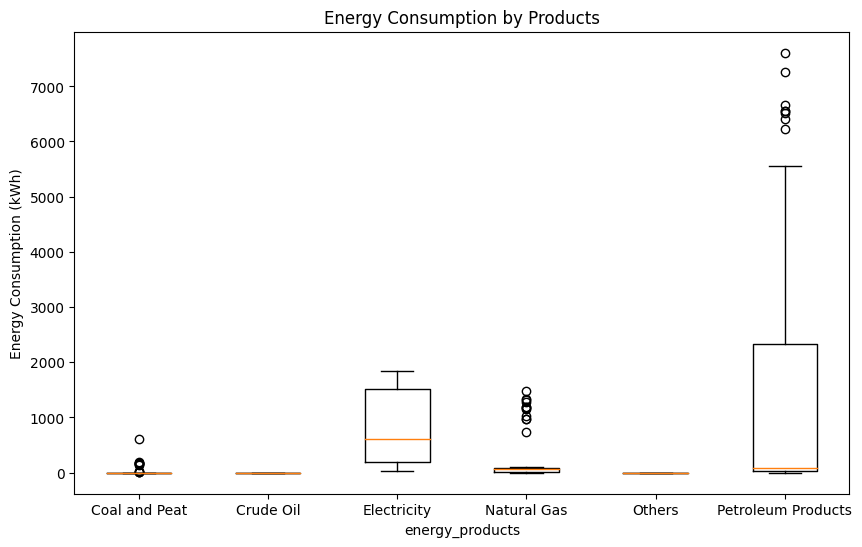

In [305]:
# Check for outliers in energy consumption
fig, ax = plt.subplots(figsize=(10, 6))
data = [energy_consumption[energy_consumption['energy_products'] == energy_products]['consumption_ktoe'] for energy_products in energy_consumption['energy_products'].unique()]
ax.boxplot(data, labels=energy_consumption['energy_products'].unique())
ax.set_title('Energy Consumption by Products')
ax.set_ylabel('Energy Consumption (kWh)')
ax.set_xlabel('energy_products')
plt.show()

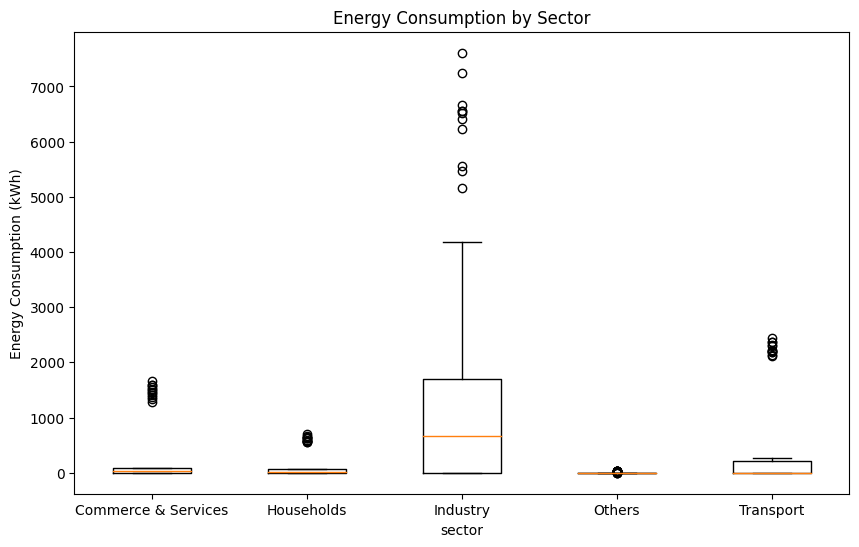

In [306]:
# Check for outliers by sector
fig, ax = plt.subplots(figsize=(10, 6))
data = [energy_consumption[energy_consumption['sector'] == sector]['consumption_ktoe'] for sector in energy_consumption['sector'].unique()]
ax.boxplot(data, labels=energy_consumption['sector'].unique())
ax.set_title('Energy Consumption by Sector')
ax.set_ylabel('Energy Consumption (kWh)')
ax.set_xlabel('sector')
plt.show()

In [307]:
print(energy_consumption.columns)

Index(['year', 'sector', 'energy_products', 'consumption_ktoe'], dtype='object')


In [308]:
# Convert from long to wide format
energy_consumption = energy_consumption.pivot(index='year', columns=['sector', 'energy_products'], values='consumption_ktoe')
energy_consumption.reset_index(inplace=True)
energy_consumption.columns = list(map("_".join, energy_consumption.columns))


In [309]:
print(energy_consumption.columns)

Index(['year_', 'Commerce & Services_Coal and Peat',
       'Commerce & Services_Crude Oil', 'Commerce & Services_Electricity',
       'Commerce & Services_Natural Gas', 'Commerce & Services_Others',
       'Commerce & Services_Petroleum Products', 'Households_Coal and Peat',
       'Households_Crude Oil', 'Households_Electricity',
       'Households_Natural Gas', 'Households_Others',
       'Households_Petroleum Products', 'Industry_Coal and Peat',
       'Industry_Crude Oil', 'Industry_Electricity', 'Industry_Natural Gas',
       'Industry_Others', 'Industry_Petroleum Products',
       'Others_Coal and Peat', 'Others_Crude Oil', 'Others_Electricity',
       'Others_Natural Gas', 'Others_Others', 'Others_Petroleum Products',
       'Transport_Coal and Peat', 'Transport_Crude Oil',
       'Transport_Electricity', 'Transport_Natural Gas', 'Transport_Others',
       'Transport_Petroleum Products'],
      dtype='object')


In [310]:
display(energy_consumption)

,year_,Commerce & Services_Coal and Peat,Commerce & Services_Crude Oil,Commerce & Services_Electricity,Commerce & Services_Natural Gas,Commerce & Services_Others,Commerce & Services_Petroleum Products,Households_Coal and Peat,Households_Crude Oil,Households_Electricity,...,Others_Electricity,Others_Natural Gas,Others_Others,Others_Petroleum Products,Transport_Coal and Peat,Transport_Crude Oil,Transport_Electricity,Transport_Natural Gas,Transport_Others,Transport_Petroleum Products
0,2009,0.0,0.0,1272.6,72.9,0.0,78.5,0.0,0.0,552.9,...,35.6,0.8,0.0,0.0,0.0,0.0,138.2,13.7,0.0,2193.3
1,2010,0.0,0.0,1330.2,78.3,0.0,84.2,0.0,0.0,570.6,...,33.1,0.8,0.0,0.0,0.0,0.0,180.5,20.8,0.0,2219.1
2,2011,0.0,0.0,1365.1,82.4,0.0,68.9,0.0,0.0,557.4,...,29.8,0.8,0.0,0.0,0.0,0.0,191.2,25.9,0.0,2366.9
3,2012,0.0,0.0,1407.2,82.5,0.0,68.3,0.0,0.0,570.0,...,26.1,0.8,0.0,0.0,0.0,0.0,200.2,20.0,0.0,2292.7
4,2013,0.0,0.0,1437.5,89.3,0.0,87.3,0.0,0.0,580.8,...,22.6,0.8,0.0,0.0,0.0,0.0,203.7,18.1,0.0,2133.3
5,2014,0.0,0.0,1465.7,85.3,0.0,78.9,0.0,0.0,595.4,...,20.4,0.8,0.0,0.0,0.0,0.0,209.9,17.4,0.0,2199.8
6,2015,0.0,0.0,1503.1,88.2,0.0,80.0,0.0,0.0,620.9,...,24.0,2.0,0.0,0.0,0.0,0.0,210.2,14.3,0.0,2364.5
7,2016,0.0,0.0,1521.9,92.1,0.0,77.3,0.0,0.0,652.3,...,24.1,2.6,0.0,0.0,0.0,0.0,226.9,11.2,0.0,2436.5
8,2017,0.0,0.0,1553.1,88.5,0.0,75.2,0.0,0.0,626.8,...,23.8,2.4,0.0,0.0,0.0,0.0,238.0,6.9,0.0,2192.0
9,2018,0.0,0.0,1597.8,87.6,0.0,74.4,0.0,0.0,621.8,...,22.2,3.8,0.0,0.0,0.0,0.0,253.6,2.8,0.0,2111.5
